In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import random
import torch
from torch.utils.data import DataLoader, TensorDataset
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
import importlib
import modules
import modules.comp.nn_based
importlib.reload(modules.comp.nn_based)
from modules.comp.nn_based import *
from sklearn.model_selection import train_test_split

In [3]:
from modules.utils.noise_create import create_1d_data

In [4]:
batch_size = 32
num_epochs = 20
train_split = 0.8

In [5]:
def plot_results(noisy, clean, denoised, title=""):
    """
    Plot a few examples comparing the noisy input, clean signal, and denoised output.
    """
    num_examples = 3
    plt.figure(figsize=(8, 4))
    for i in range(num_examples):
        plt.subplot(num_examples, 1, i+1)
        plt.plot(clean[i].squeeze().cpu().numpy(), label="Clean Signal", linewidth=2)
        plt.plot(noisy[i].squeeze().cpu().numpy(), label="Noisy Signal", alpha=0.5)
        plt.plot(denoised[i].squeeze().cpu().detach().numpy(), label="Denoised Output", linestyle="--")
        plt.legend(loc="upper right")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

##### 1D Noisy Signal Generation (Flat PSD + White Noise)
Observation = Sine Wave + Noise ~ N(0, 1)

(10000, 100) (10000, 100) (10000, 100)


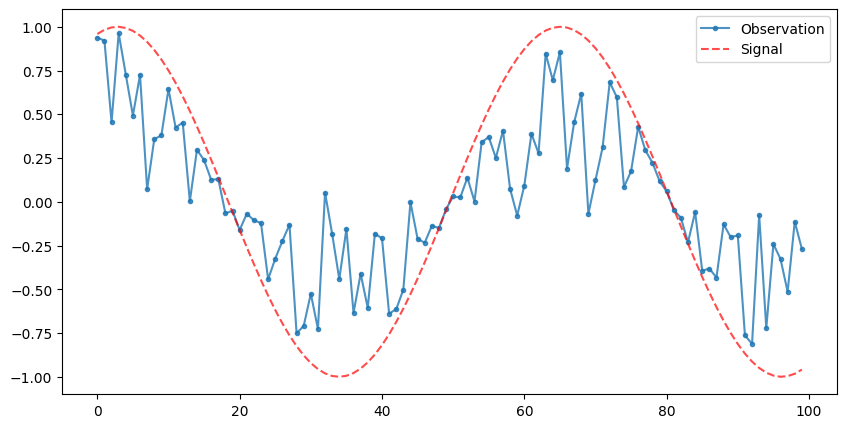

In [6]:
n_samples = 10000
rn = random.randint(0, n_samples)

observation, signal, noise = create_1d_data(n_samples=n_samples)
print(observation.shape, signal.shape, noise.shape)

plt.figure(figsize=(10, 5))

plt.plot(observation[rn], label="Observation", alpha=0.8, marker='.')
plt.plot(signal[rn], label="Signal", linestyle="dashed", alpha=0.7, color = 'red')
plt.legend()
plt.show()


In [7]:
observation_train, observation_val, signal_train, signal_val = train_test_split(observation, signal, test_size = 1 - train_split, random_state=28)

print('Shape: ', observation_train.shape, signal_train.shape, observation_val.shape, signal_val.shape)

observation_train = torch.tensor(observation_train, dtype=torch.float32)
signal_train = torch.tensor(signal_train, dtype=torch.float32)
observation_val = torch.tensor(observation_val, dtype=torch.float32)
signal_val = torch.tensor(signal_val, dtype=torch.float32)

dataset_train = TensorDataset(observation_train, signal_train)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = TensorDataset(observation_val, signal_val)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

print(train_loader, val_loader)

Shape:  (8000, 100) (8000, 100) (2000, 100) (2000, 100)
<torch.utils.data.dataloader.DataLoader object at 0x0000027B322CF560> <torch.utils.data.dataloader.DataLoader object at 0x0000027B321C7E90>


### Baselines/Benchmarks (used in GDiff Paper + Added)

1. BM3D (non-trainable): Block-Matching and 3D Filtering (Collaborative Filtering)
2. DnCNN: Denoising Convolutional Neural Network (Residual Prediction)
3. DAE: Denoising Autoencoder (Signal Predictor)
4. Denoising CNN (Signal Predictor)

#### Denoising Autoencoder (DAE) - (Noise -> Signal)

Training Denoising Autoencoder (DAE)...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 100]              64
              ReLU-2              [-1, 16, 100]               0
         AvgPool1d-3               [-1, 16, 50]               0
            Conv1d-4                [-1, 8, 50]             392
              ReLU-5                [-1, 8, 50]               0
         AvgPool1d-6                [-1, 8, 25]               0
            Conv1d-7                [-1, 8, 25]             200
              ReLU-8                [-1, 8, 25]               0
          Upsample-9                [-1, 8, 50]               0
           Conv1d-10               [-1, 16, 50]             400
             ReLU-11               [-1, 16, 50]               0
         Upsample-12              [-1, 16, 100]               0
           Conv1d-13               [-1, 1, 100]              49

Epoch [1/20] Train Loss: 0.0954 | Val Loss: 0.0089


Epoch [2/20] Train Loss: 0.0068 | Val Loss: 0.0055


Epoch [3/20] Train Loss: 0.0049 | Val Loss: 0.0047


Epoch [4/20] Train Loss: 0.0040 | Val Loss: 0.0036


Epoch [5/20] Train Loss: 0.0034 | Val Loss: 0.0031


Epoch [6/20] Train Loss: 0.0030 | Val Loss: 0.0029


Epoch [7/20] Train Loss: 0.0029 | Val Loss: 0.0027


Epoch [8/20] Train Loss: 0.0027 | Val Loss: 0.0026


Epoch [9/20] Train Loss: 0.0026 | Val Loss: 0.0026


Epoch [10/20] Train Loss: 0.0025 | Val Loss: 0.0025


Epoch [11/20] Train Loss: 0.0025 | Val Loss: 0.0027


Epoch [12/20] Train Loss: 0.0025 | Val Loss: 0.0023


Epoch [13/20] Train Loss: 0.0024 | Val Loss: 0.0028


Epoch [14/20] Train Loss: 0.0024 | Val Loss: 0.0027


Epoch [15/20] Train Loss: 0.0024 | Val Loss: 0.0022


Epoch [16/20] Train Loss: 0.0023 | Val Loss: 0.0022


Epoch [17/20] Train Loss: 0.0023 | Val Loss: 0.0022


Epoch [18/20] Train Loss: 0.0023 | Val Loss: 0.0022


Epoch [19/20] Train Loss: 0.0022 | Val Loss: 0.0022


Epoch [20/20] Train Loss: 0.0022 | Val Loss: 0.0022


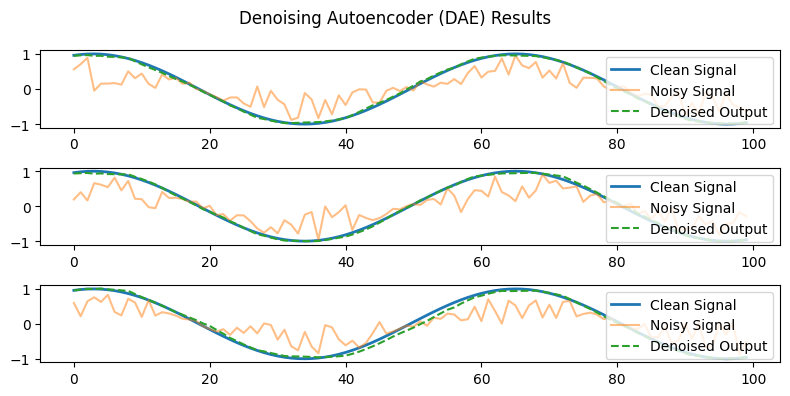

In [7]:
# ----- Denoising Autoencoder (DAE) -----

print("Training Denoising Autoencoder (DAE)...")
dae = DenoisingAutoencoder()
dae.summary()

dae, train_loss, val_loss = train_model(dae, train_loader=train_loader, val_loader=val_loader, num_epochs=num_epochs, return_loss=True)

# Evaluate DAE on a few examples
dae.eval()
device = next(dae.parameters()).device

with torch.no_grad():
    sample_noisy = observation_val[:3].to(device)
    sample_noisy = sample_noisy.reshape(sample_noisy.shape[0], 1, -1)
    dae_output = dae(sample_noisy)

plot_results(observation_val, signal_val, dae_output, title="Denoising Autoencoder (DAE) Results")

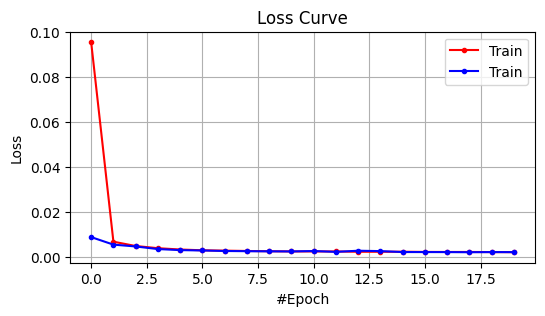

In [ ]:
fig = plt.figure(figsize = (6, 3))

plt.plot(range(0, num_epochs), train_loss, label = 'Train', color = 'red', marker = '.')
plt.plot(range(0, num_epochs), val_loss, label = 'Val', color = 'blue', marker = '.')
plt.xlabel('#Epoch')
plt.ylabel('Loss')

plt.title('Loss Curve')

plt.legend()
plt.grid()
plt.show()

#### CNN - Based Denoising  (Noise -> Signal)

Training Basic CNN for Denoising...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 100]             128
              Tanh-2              [-1, 32, 100]               0
            Conv1d-3              [-1, 64, 100]           6,208
              Tanh-4              [-1, 64, 100]               0
            Conv1d-5              [-1, 64, 100]          12,352
              Tanh-6              [-1, 64, 100]               0
            Conv1d-7              [-1, 32, 100]           6,176
              Tanh-8              [-1, 32, 100]               0
            Conv1d-9               [-1, 1, 100]              97
Total params: 24,961
Trainable params: 24,961
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.29
Params size (MB): 0.10
Estimated Total Size (MB): 0.39
---------

Epoch [1/20] Train Loss: 0.0247 | Val Loss: 0.0118


Epoch [2/20] Train Loss: 0.0113 | Val Loss: 0.0105


Epoch [3/20] Train Loss: 0.0095 | Val Loss: 0.0088


Epoch [4/20] Train Loss: 0.0084 | Val Loss: 0.0077


Epoch [5/20] Train Loss: 0.0077 | Val Loss: 0.0075


Epoch [6/20] Train Loss: 0.0071 | Val Loss: 0.0067


Epoch [7/20] Train Loss: 0.0067 | Val Loss: 0.0076


Epoch [8/20] Train Loss: 0.0063 | Val Loss: 0.0059


Epoch [9/20] Train Loss: 0.0060 | Val Loss: 0.0057


Epoch [10/20] Train Loss: 0.0058 | Val Loss: 0.0059


Epoch [11/20] Train Loss: 0.0056 | Val Loss: 0.0056


Epoch [12/20] Train Loss: 0.0053 | Val Loss: 0.0053


Epoch [13/20] Train Loss: 0.0052 | Val Loss: 0.0051


Epoch [14/20] Train Loss: 0.0051 | Val Loss: 0.0050


Epoch [15/20] Train Loss: 0.0049 | Val Loss: 0.0052


Epoch [16/20] Train Loss: 0.0048 | Val Loss: 0.0048


Epoch [17/20] Train Loss: 0.0048 | Val Loss: 0.0048


Epoch [18/20] Train Loss: 0.0046 | Val Loss: 0.0045


Epoch [19/20] Train Loss: 0.0045 | Val Loss: 0.0044


Epoch [20/20] Train Loss: 0.0044 | Val Loss: 0.0043


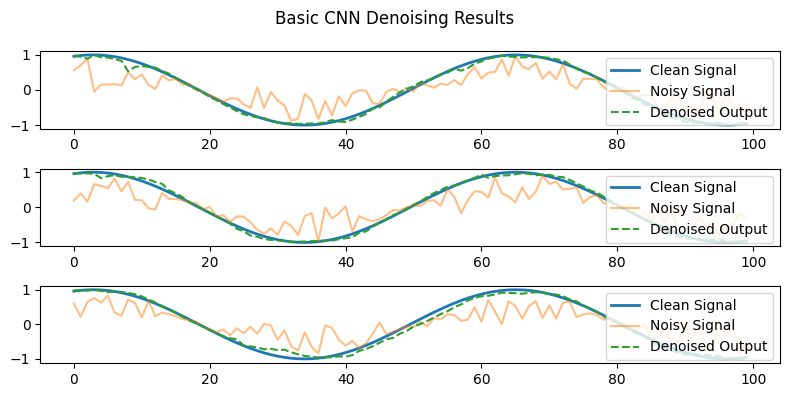

In [9]:
# ----- Basic CNN for Denoising -----

num_epochs = 20

print("Training Basic CNN for Denoising...")
cnn = DenoisingCNN()
cnn.summary()

cnn, train_loss, val_loss = train_model(cnn, train_loader=train_loader, val_loader=val_loader, num_epochs=num_epochs, return_loss=True)

# Evaluate CNN on a few examples
cnn.eval()
device = next(cnn.parameters()).device

with torch.no_grad():
    sample_noisy = observation_val[:3].to(device)
    sample_noisy = sample_noisy.reshape(sample_noisy.shape[0], 1, -1)
    cnn_output = cnn(sample_noisy)

plot_results(observation_val, signal_val, cnn_output, title="Basic CNN Denoising Results")

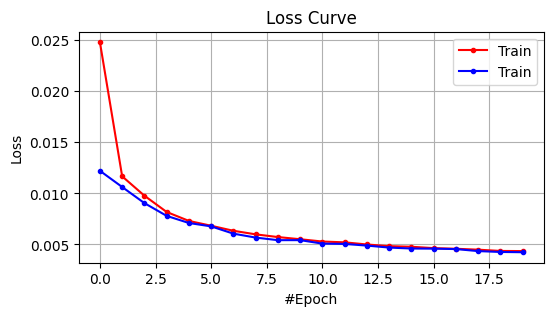

In [ ]:
fig = plt.figure(figsize = (6, 3))

plt.plot(range(0, num_epochs), train_loss, label = 'Train', color = 'red', marker = '.')
plt.plot(range(0, num_epochs), val_loss, label = 'Val', color = 'blue', marker = '.')
plt.xlabel('#Epoch')
plt.ylabel('Loss')

plt.title('Loss Curve')

plt.legend()
plt.grid()
plt.show()

## Paper Benchmarks

#### DnCNN (Noise -> Residual)

#### BM3D (Collab. Filtering)

#### DDPM Denoising (1D) - time-reversal

The reverse diffusion process is a parameterized posterior sampling method $q_\theta(x_{t-1} \mid x_t)$ which approximates the forward process $p(x_{t-1} \mid x_t, x_0)$.

We perform sampling (ancestral) or inference by running the reverse process from isotropic Gaussian noise to the target distribution  in discrete time steps.

3 Way - Model

noise-estimator -> diffusion-framework -> trainer

Very Modularized Implementation

```

### We seperately pass a estimation model to the diffusion architechture (for say noise residual estimation) 
model = Unet1D(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    channels = 32
)

diffusion = GaussianDiffusion1D(
    model,
    seq_length = 128,
    timesteps = 1000,
    objective = 'pred_v'
)

trainer = Trainer(
    diffusion,
    'path/to/your/images',
    train_batch_size = 32,
    train_lr = 8e-5,
    train_num_steps = 700000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
    calculate_fid = True              # whether to calculate fid during training
)

trainer.train()
```

<b>One Possible Extension </b>: Add a time-reversal based DDPM denoiser with joint t-regressor

In [113]:
from modules.comp import unet
from modules.comp.diffusion_1d import GaussianDiffusion1D 
from modules.comp.diff_trainer import Trainer1D as Trainer

In [114]:
importlib.reload(unet)
importlib.reload(modules.comp.diffusion_1d)
importlib.reload(modules.comp.diff_trainer)

from modules.comp import unet
from modules.comp.diffusion_1d import GaussianDiffusion1D 
from modules.comp.diff_trainer import Trainer1D as Trainer

In [115]:
print(type(observation), observation.shape, signal.shape, noise.shape)
print(type(signal_train), signal_train.shape)

<class 'numpy.ndarray'> (10000, 100) (10000, 100) (10000, 100)
<class 'torch.Tensor'> torch.Size([8000, 100])


In [11]:
diffusion_timesteps = 1000

In [ ]:
model = unet.Unet1D(
    dim = 12, ## ? Something is wrong here?
    out_dim = 1,
    dim_mults=(1, 2),
    channels=1
)
## time-embedding shape -> t = torch.randint(0, self.num_timesteps, (b,), device=device).long() --> (b, )
t_shape = (1, )
x_shape = (1, 1, 100)

print(x_shape, t_shape)

print('- UNET-summary -')
model.summary(x_shape=x_shape, t_shape=t_shape)

### Just the diffusion framework
diffusion = GaussianDiffusion1D(
    model,
    seq_length = 100,
    timesteps = diffusion_timesteps,
)

Train: We supply clean 1D signals -> Does Noise prediction (with respective gaussian noise) -> Learns signal distrib. 

Inference: Instead of Isotropic Gaussian Noise, we supply Noisy Signal for denoising (assume x_t)

In [65]:
trainer = Trainer(
    diffusion,
    signal_train,
    train_batch_size = 8,
    train_lr = 1e-4,
    train_num_steps = 1000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
)

trainer.train()

Optimization Steps: 100%|██████████| 1000/1000 [07:30<00:00,  2.22it/s]

Training complete.


#### Inferencing/Denoising

Can't use vanilla 'generation' ancestral sampling schema to denoise --> don't know t --> Can train a t regressor jointly with noise estimator --> Gdiff Paper uses a score based SDE

1. Fixed Temporal parameter (t) | Deterministic 

In [66]:
sampled_seq = diffusion.sample(batch_size = 1)
sampled_seq.shape ## rabdom-samplijng from p(x_0) marginal

sampling loop time step: 100%|██████████| 1000/1000 [00:18<00:00, 54.34it/s]


torch.Size([1, 1, 100])

Random-Sample from <code>p(x_0)</code> marginal

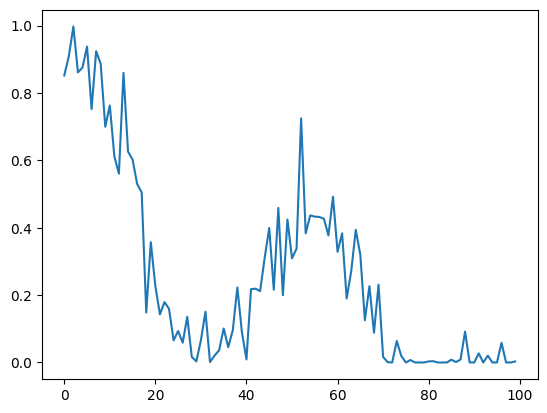

In [67]:
plt.plot(sampled_seq[0][0])
plt.show()

In [68]:
timesteps = 1000
test_t = 50
test_t = torch.tensor([test_t])

scale = 1000 / timesteps
beta_start = scale * 0.0001
beta_end = scale * 0.02
beta = torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float64)
alpha = 1. - beta
alpha_cumprod = torch.cumprod(alpha, dim=0)[test_t[0]]
inv_sqrt_alpha_cumprod = 1/(np.sqrt(alpha_cumprod)) 
sqrt_one_minus_alpha_cumprod = np.sqrt(1 - alpha_cumprod)

print('alpha_cumprod: ', alpha_cumprod.item())

x_0 = torch.unsqueeze(torch.unsqueeze(signal_train[4], dim=0), dim=0)
print('Original_Signal: ', x_0.shape)

x_t = diffusion.q_sample(x_start=x_0, t=test_t)
preds = diffusion.model_predictions(x_t, test_t)
pred_noise = preds.pred_noise
print('Pred Noise: ', pred_noise.shape)

x_0_hat = (inv_sqrt_alpha_cumprod * (x_t -  (sqrt_one_minus_alpha_cumprod * pred_noise))).detach().cpu().numpy()

print('Pred_Signal: ', x_0_hat.shape) 

alpha_cumprod:  0.9699514935950494
Original_Signal:  torch.Size([1, 1, 100])
Pred Noise:  torch.Size([1, 1, 100])
Pred_Signal:  (1, 1, 100)


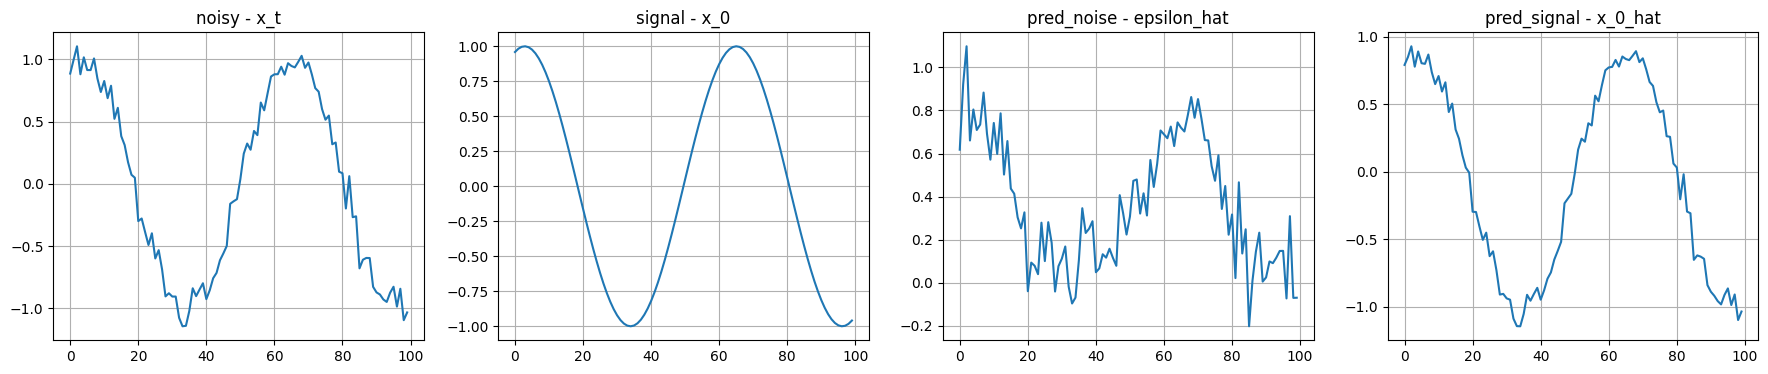

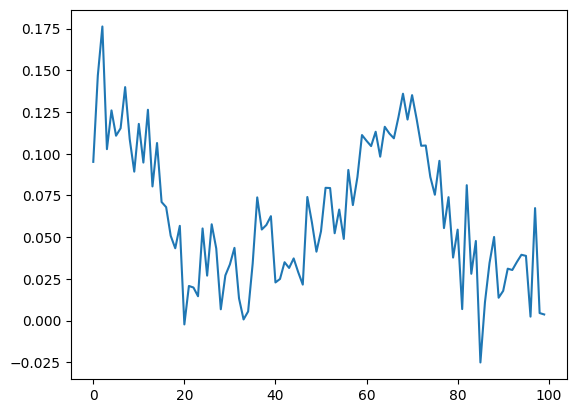

In [69]:
fig, axs = plt.subplots(1, 4, figsize=(22, 4))

noisy_x_t = x_t.detach().cpu().numpy()
pred_noise_hat = pred_noise.detach().cpu().numpy()

axs[0].plot(noisy_x_t[0][0])
axs[0].set_title('noisy - x_t')
axs[0].grid()

axs[1].plot(x_0[0][0])
axs[1].set_title('signal - x_0')
axs[1].grid()

axs[2].plot(pred_noise_hat[0][0])
axs[2].set_title('pred_noise - epsilon_hat')
axs[2].grid()

axs[3].plot(x_0_hat[0][0])
axs[3].set_title('pred_signal - x_0_hat')
axs[3].grid()

plt.show()

plt.plot(noisy_x_t[0][0] - x_0_hat[0][0])
plt.show()

2. Regress t parameter

In [116]:
model = unet.Unet1D(
    dim = 12, ## ? Something is wrong here?
    out_dim = 1,
    timesteps = diffusion_timesteps,
    dim_mults=(1, 2),
    channels=1
)
## time-embedding shape -> t = torch.randint(0, self.num_timesteps, (b,), device=device).long() --> (b, )
t_shape = (1, )
x_shape = (1, 1, 100)

print(x_shape, t_shape)

print('- UNET-summary -')
model.summary(x_shape=x_shape)

### Just the diffusion framework
diffusion = GaussianDiffusion1D(
    model,
    seq_length = 100,
    timesteps = diffusion_timesteps,
)

Obtained-Dimensionalities:  [12, 12, 24] [(12, 12), (12, 24)]
(1, 1, 100) (1,)
- UNET-summary -
____________________________________________________________________________________________________
Model: Unet1D
Layer (type)                            Output Shape             Param #        
input_1 (InputLayer)                    (1, 1, 100)              0              
custom_time_layer.predict_time.0 (AdaptiveAvgPool1d)(1, 12, 1)               0              
custom_time_layer.predict_time.1 (Flatten)(1, 12)                  0              
custom_time_layer.predict_time.2 (Linear)(1, 6)                   78             
custom_time_layer.predict_time.3 (GELU) (1, 6)                   0              
custom_time_layer.predict_time.4 (Linear)(1, 1)                   7              
custom_time_layer.predict_time.5 (Sigmoid)(1, 1)                   0              
custom_time_layer.predict_time (Sequential)(1, 1)                   85             
time_mlp.0 (SinusoidalPosEmb)          

In [117]:
trainer = Trainer(
    diffusion,
    signal_train,
    train_batch_size = 8,
    train_lr = 1e-4,
    train_num_steps = 10000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
)

## sampling-loops-time are not traced - they are just checkpointing
trainer.train()

Optimization Steps: 100%|██████████| 10000/10000 [24:07<00:00,  6.91it/s]

Training complete.


In [189]:
timesteps = 1000
test_t = 393
print('Selected-t: ', test_t)
test_t = torch.tensor([test_t])

scale = 1000 / timesteps
beta_start = scale * 0.0001
beta_end = scale * 0.02
beta = torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float64)

alpha = 1. - beta
alpha_cumprod = torch.cumprod(alpha, dim=0)[test_t[0]]
inv_sqrt_alpha_cumprod = 1/(np.sqrt(alpha_cumprod)) 
sqrt_one_minus_alpha_cumprod = np.sqrt(1 - alpha_cumprod)

print('alpha_cumprod: ', alpha_cumprod.item())

x_0 = torch.unsqueeze(torch.unsqueeze(signal_train[4], dim=0), dim=0)
print('Original_Signal: ', x_0.shape)

### use a randomly noised x_t (Unknown)
x_t = diffusion.q_sample(x_start=x_0, t=test_t)
preds = diffusion.model_predictions(x_t)
pred_noise, pred_t = preds.pred_noise, preds.pred_t

print('Pred Noise: ', pred_noise.shape)
print('Pred Time: ', pred_t.shape, pred_t.item())

alpha = 1. - beta
alpha_cumprod = torch.cumprod(alpha, dim=0)[pred_t.item()]
inv_sqrt_alpha_cumprod = 1/(np.sqrt(alpha_cumprod)) 
sqrt_one_minus_alpha_cumprod = np.sqrt(1 - alpha_cumprod)

x_0_hat = (inv_sqrt_alpha_cumprod * (x_t -  (sqrt_one_minus_alpha_cumprod * pred_noise))).detach().cpu().numpy()

print('Pred_Signal: ', x_0_hat.shape) 

Selected-t:  393
alpha_cumprod:  0.20477927972141746
Original_Signal:  torch.Size([1, 1, 100])
Pred Noise:  torch.Size([1, 1, 100])
Pred Time:  torch.Size([1]) 527
Pred_Signal:  (1, 1, 100)


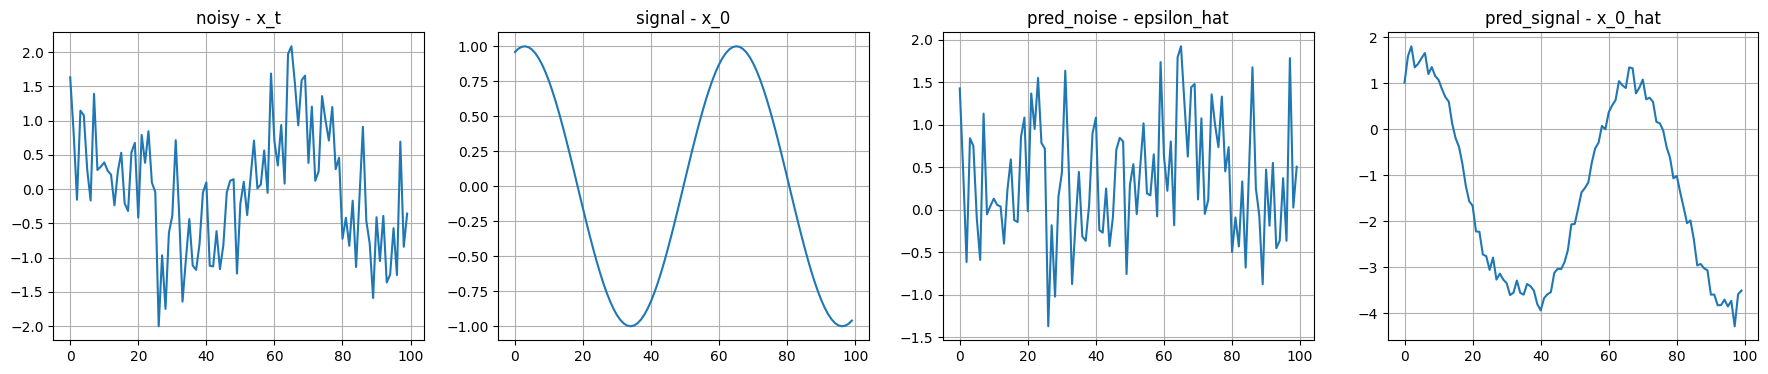

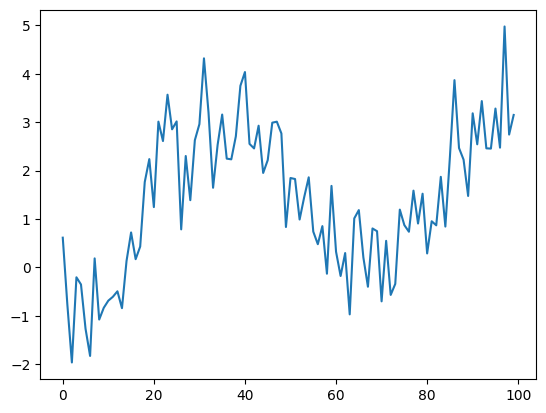

In [190]:
fig, axs = plt.subplots(1, 4, figsize=(22, 4))

noisy_x_t = x_t.detach().cpu().numpy()
pred_noise_hat = pred_noise.detach().cpu().numpy()

axs[0].plot(noisy_x_t[0][0])
axs[0].set_title('noisy - x_t')
axs[0].grid()

axs[1].plot(x_0[0][0])
axs[1].set_title('signal - x_0')
axs[1].grid()

axs[2].plot(pred_noise_hat[0][0])
axs[2].set_title('pred_noise - epsilon_hat')
axs[2].grid()

axs[3].plot(x_0_hat[0][0])
axs[3].set_title('pred_signal - x_0_hat')
axs[3].grid()

plt.show()

plt.plot(noisy_x_t[0][0] - x_0_hat[0][0])
plt.show()